In [1]:
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn import svm, cross_validation, metrics, preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import seaborn as sb

client = pymongo.MongoClient()
db = client.VentDB
#ventSettings = db.VentSettings_collection
#breathData = db.BreathData_collection
validData = db.train_collection

%matplotlib inline

In [2]:
validData.find({'validation':{'$exists':1}}).count()

1873

In [3]:
data = validData.find({'validation':{'$exists':1}}, {'validation':1, 'breath_character':1, 'breath_settings':1, 
                                                     'max_min_analysis':1, 'next_breath_data':1, '_id':0})
df = pd.io.json.json_normalize(list(data))

In [4]:
for x in range(15):
    print(df.columns[(x*10):(x*10+10)])

Index(['breath_character.elapse_time', 'breath_character.end_insp_flow',
       'breath_character.end_insp_paw', 'breath_character.end_insp_time',
       'breath_character.end_insp_vol', 'breath_character.end_time',
       'breath_character.exp_time', 'breath_character.insp_time',
       'breath_character.mean_exp_flow', 'breath_character.mean_exp_paw'],
      dtype='object')
Index(['breath_character.mean_insp_flow', 'breath_character.mean_insp_paw',
       'breath_character.min_exp_flow', 'breath_character.min_exp_paw',
       'breath_character.min_exp_vol', 'breath_character.min_flow',
       'breath_character.min_paw', 'breath_character.min_vol',
       'breath_character.n_dF/dP_exp_max',
       'breath_character.n_dF/dP_insp_max'],
      dtype='object')
Index(['breath_character.n_dF/dV_exp_max', 'breath_character.n_dF/dV_insp_max',
       'breath_character.n_dP/dV_exp_max', 'breath_character.n_dP/dV_insp_max',
       'breath_character.peak_flow', 'breath_character.peak_paw',
      

In [5]:
df.replace({np.nan:0}, inplace=True)
df['breath_settings.vent_mode'] = df['breath_settings.vent_mode'].astype('category')
print(df['breath_settings.vent_mode'].value_counts)
df = df[(df['breath_settings.vent_mode'] == 'APVCMV') | (df['breath_settings.vent_mode'] == 'PCMV')]
df.drop(['breath_settings.vent_mode', 'breath_settings.i:e', 'breath_settings.file'], inplace=True, axis=1)
df.shape

<bound method IndexOpsMixin.value_counts of 0        SPONT
1       APVCMV
2       APVCMV
3       APVCMV
4       APVCMV
5       APVCMV
6        SPONT
7        SPONT
8       APVCMV
9        SPONT
10        PCMV
11      APVCMV
12      APVCMV
13      APVCMV
14      APVCMV
15      APVCMV
16      APVCMV
17      APVCMV
18      APVCMV
19      APVCMV
20      APVCMV
21      APVCMV
22        PCMV
23      APVCMV
24      APVCMV
25        PCMV
26      APVCMV
27      APVCMV
28      APVCMV
29      APVCMV
         ...  
1843    APVCMV
1844    APVCMV
1845    APVCMV
1846     SPONT
1847    APVCMV
1848    APVCMV
1849    APVCMV
1850    APVCMV
1851    APVCMV
1852    APVCMV
1853    APVCMV
1854    APVCMV
1855    APVCMV
1856    APVCMV
1857    APVCMV
1858    APVCMV
1859    APVCMV
1860    APVCMV
1861    APVCMV
1862    APVCMV
1863    APVCMV
1864    APVCMV
1865    APVCMV
1866    APVCMV
1867    APVCMV
1868    APVCMV
1869      APRV
1870    APVCMV
1871    APVCMV
1872    APVCMV
Name: breath_settings.vent_mode, dtype: c

(1638, 183)

In [6]:
df = df[(df['breath_character.peak_vol'] < 2000) & (df['breath_character.peak_vol'] > 100) & (df['breath_character.elapse_time'] < 6000)]
df.shape

(1580, 183)

In [12]:
y = df['validation.pfl'].values #All data points is better
x = df[['max_min_analysis.sm_paw.shoulder_amp',
       'max_min_analysis.sm_paw.shoulder_time',
       'max_min_analysis.sm_paw.shoulder_time_percent', 
       #'max_min_analysis.sm_paw.n_insp_max',
       #'max_min_analysis.sm_paw.n_insp_max_25',
       #'max_min_analysis.sm_paw.n_insp_max_50',
       #'max_min_analysis.sm_paw.n_insp_max_75',
       #'max_min_analysis.sm_paw.n_insp_max_90',
       #'max_min_analysis.sm_paw.n_insp_min',
       #'max_min_analysis.sm_paw.n_insp_min_25',
       #'max_min_analysis.sm_paw.n_insp_min_50',
       #'max_min_analysis.sm_paw.n_insp_min_75', 
       'max_min_analysis.sm_paw.insp_ptp_rel_position',
       'max_min_analysis.sm_paw.insp_ptp_time_delta',
       'max_min_analysis.sm_paw.insp_rise',
       'max_min_analysis.sm_paw.insp_rise_25',
       'max_min_analysis.sm_paw.insp_rise_50',
       'max_min_analysis.sm_paw.insp_rise_75',
       ]].values

In [77]:
y = df['validation.ie'].values
x = df[['breath_character.exp_time',
        'max_min_analysis.sm_flow.n_exp_max_50',
        'max_min_analysis.sm_flow.n_exp_max_75',
        #'max_min_analysis.sm_paw.n_exp_max_50',
        #'max_min_analysis.sm_paw.n_exp_max_75',
        #'max_min_analysis.sm_vol.n_exp_max_50',
        #'breath_character.n_dP/dV_exp_max',
        #'breath_character.n_dF/dV_exp_max', 
        'breath_character.n_dF/dP_exp_max',
        #'breath_settings.auto_peep'
    ]].values

In [9]:
y = df['validation.garb'].values
x = df[['breath_character.exp_time',
        'breath_character.peak_vol'
    ]].values

In [7]:
y = df['validation.pfl'].values
x = df.drop(['validation.norm', 'validation.ds', 'validation.pds', 'validation.fa', 'validation.pfl', 'validation.pvt',
             'validation.ie', 'validation.garb'], axis=1).values

clf = RandomForestClassifier(n_estimators=1000, bootstrap=True)
clf.fit(x,y)
df['predict.garb'] = clf.predict(x)
#df['predict.pfl'] = cross_validation.cross_val_predict(clf, x, y, cv=3, n_jobs=-1)

In [16]:
y = df['validation.ds'].values
x = df.drop(['validation.norm', 'validation.ds', 'validation.pds', 'validation.fa', 'validation.pfl', 'validation.pvt',
             'validation.ie', 'validation.garb'], axis=1).values

In [7]:
y = df['validation.ds'].values
x = df[[
        'breath_character.insp_time',
        'breath_character.exp_time', 
        'breath_character.elapse_time', 
        #'breath_character.end_insp_flow',
        #'breath_character.end_insp_paw', 
        #'breath_character.end_insp_vol', 
        #'breath_character.mean_exp_flow', 
        #'breath_character.mean_exp_paw',
        #'breath_character.mean_insp_flow', 
        #'breath_character.mean_insp_paw',
        #'breath_character.min_exp_flow', 
        #'breath_character.min_exp_paw',
        'breath_character.min_exp_vol', 
        #'breath_character.min_flow',
        #'breath_character.min_paw', 
        'breath_character.min_vol',
        #'breath_character.peak_flow', 
        #'breath_character.peak_paw',
        #'breath_character.peak_vol',
        'next_breath_data.min_exp_vol',
        #'next_breath_data.min_exp_flow',
        #'next_breath_data.min_exp_paw',
        #'next_breath_data.insp_time',
        #'next_breath_data.exp_time',
        #'next_breath_data.end_insp_flow',
        #'next_breath_data.end_insp_vol',
       ]].values

In [8]:
x[0]

array([  608.,   992.,  1600.,   -30.,   -30.,   -55.])

In [10]:
df.head(1)

,breath_character.elapse_time,breath_character.end_insp_flow,breath_character.end_insp_paw,breath_character.end_insp_time,breath_character.end_insp_vol,breath_character.end_time,breath_character.exp_time,breath_character.insp_time,breath_character.mean_exp_flow,breath_character.mean_exp_paw,...,next_breath_data.peak_vol,next_breath_data.start_time,validation.ds,validation.fa,validation.garb,validation.ie,validation.norm,validation.pds,validation.pfl,validation.pvt
1,1600,3.45,19.9,7857074,400.0,7858066,992,608,-27.696774,7.493548,...,377.5,7858098.0,0,0,0,0,1,0,0,0


In [7]:
# = preprocessing.StandardScaler().fit(x)
#x = scaler.transform(x)

In [8]:
class_types = [svm.SVC(C=10), RandomForestClassifier(n_estimators=1000, bootstrap=True), \
               GaussianNB(), AdaBoostClassifier()]
clf =  class_types[2]
        
for scores in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    results = cross_validation.cross_val_score(clf, x, y, cv=3, scoring=scores, n_jobs=-1)
    print(scores, ': ', np.mean(results), '+/-', np.std(results))
   
results = cross_validation.cross_val_predict(clf, x, y, cv=3, n_jobs=1)
new_df = pd.DataFrame({'validated':y, 'test':results})
new_df['true_pos'] = new_df.apply(lambda x: 1 if (x.validated == 1 and x.test == 1) else 0, axis=1)
new_df['true_negs'] = new_df.apply(lambda x: 1 if (x.validated == 0 and x.test == 0) else 0, axis=1)

sensitivity = new_df['true_pos'].value_counts()[1]/np.bincount(y)[1]
specificity = new_df['true_negs'].value_counts()[1]/np.bincount(y)[0]
print('')
print('Specificity: ', specificity)
print('Sensitivity: ', sensitivity)
print('Recall is sensitivity')
print()

accuracy :  0.954147463027 +/- 0.0493391842853
precision :  0.761698651092 +/- 0.23738314519
recall :  0.939319727891 +/- 0.0438407798249
f1 :  0.821522799511 +/- 0.168928440793
roc_auc :  0.971444802235 +/- 0.0276203957758

Specificity:  0.955704697987
Sensitivity:  0.939189189189
Recall is sensitivity



In [34]:
from sklearn.externals import joblib

model = clf.fit(x,y)
joblib.dump(model, 'c:\Research_data\VD_models\ds\ds.pkl')

['c:\\Research_data\\VD_models\\ds\\ds.pkl',
 'c:\\Research_data\\VD_models\\ds\\ds.pkl_01.npy',
 'c:\\Research_data\\VD_models\\ds\\ds.pkl_02.npy',
 'c:\\Research_data\\VD_models\\ds\\ds.pkl_03.npy',
 'c:\\Research_data\\VD_models\\ds\\ds.pkl_04.npy',
 'c:\\Research_data\\VD_models\\ds\\ds.pkl_05.npy']

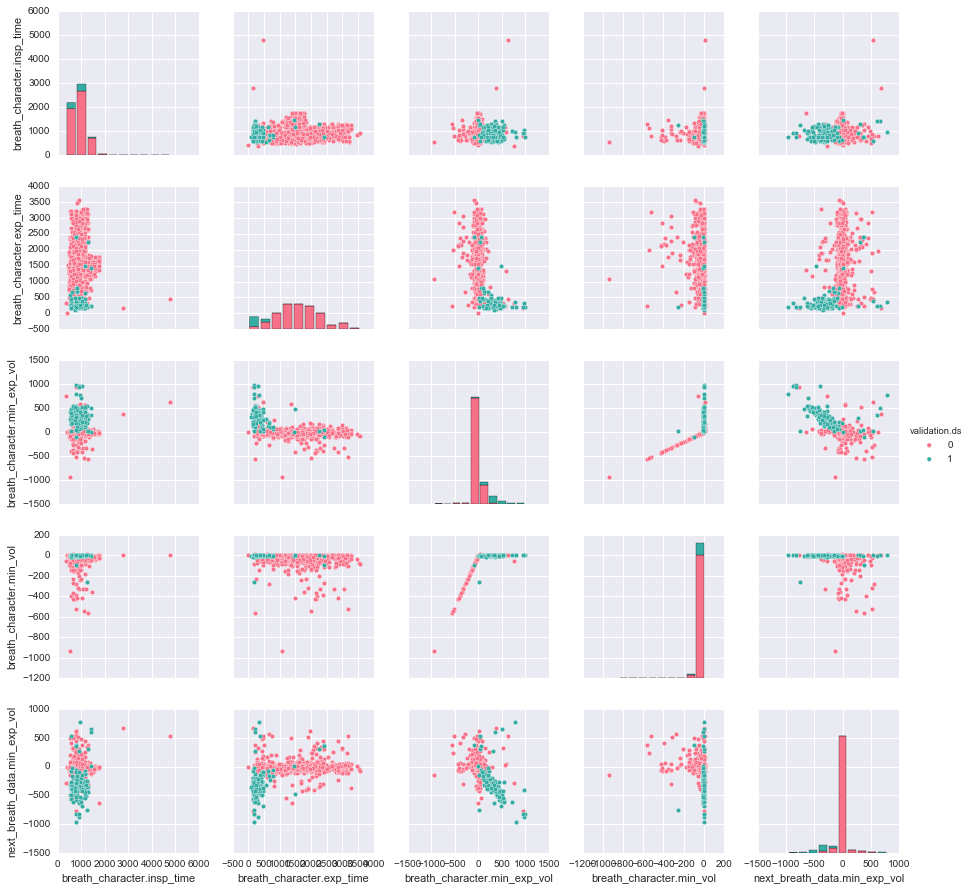

In [51]:
rows = [    'breath_character.insp_time',
        'breath_character.exp_time', 
        #'breath_character.elapse_time', 
        #'breath_character.end_insp_flow',
        #'breath_character.end_insp_paw', 
        #'breath_character.end_insp_vol', 
        #'breath_character.mean_exp_flow', 
        #'breath_character.mean_exp_paw',
        #'breath_character.mean_insp_flow', 
        #'breath_character.mean_insp_paw',
        #'breath_character.min_exp_flow', 
        #'breath_character.min_exp_paw',
        'breath_character.min_exp_vol', 
        #'breath_character.min_flow',
        #'breath_character.min_paw', 
        'breath_character.min_vol',
        #'breath_character.peak_flow', 
        #'breath_character.peak_paw',
        #'breath_character.peak_vol',
        'next_breath_data.min_exp_vol',
        #'next_breath_data.min_exp_flow',
        #'next_breath_data.min_exp_paw',
        #'next_breath_data.insp_time',
        #'next_breath_data.exp_time',
        #'next_breath_data.end_insp_flow',
        #'next_breath_data.end_insp_vol',
       ]

sb.pairplot(df, hue='validation.ds', palette='husl', vars = rows)